In [39]:
# import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline


In [40]:
# Load data
df = pd.read_csv('garments_worker_productivity.csv')


In [41]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

As observed, there are 1197 rows and 15 columns


In [42]:
df.isna().sum()


date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

There are a many null values in the 'wip' column which means we need to either impute the values or drop the null values. However, the latter method is not advised since there are 506 null values to 691 non-null values in the column. Therefore, we need to fill null values with the mean of the column.


In [43]:
df['wip'].fillna(int(df['wip'].mean()), inplace=True)


In [44]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    1197 non-null   float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

As observed, there are 4 columns with object datatypes which is 'date','quarter','department' and 'day'.


In [45]:
df.describe(include=['O'])


,date,quarter,department,day
count,1197,1197,1197,1197
unique,59,5,3,6
top,3/11/2015,Quarter1,sweing,Wednesday
freq,24,360,691,208


In [46]:
# convert date object to datetime object
df['date'] = pd.to_datetime(df['date'])


In [47]:
df.head()


,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,1190.0,960,0,0.0,0,0,8.0,0.886500
2,2015-01-01,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,2015-01-01,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,2015-01-01,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [48]:
df['quarter'].unique()


array(['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5'],
      dtype=object)

In [49]:
df['day'].unique()


array(['Thursday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday'],
      dtype=object)

In [50]:
df['department'].unique()


array(['sweing', 'finishing ', 'finishing'], dtype=object)

There are 3 unique values in the 'department' columns instead of two which is 'sewing' and 'finishing'.


In [51]:
df['department'] = df['department'].apply(
    lambda x: 'finishing' if x == ('finishing' or 'finishing ')else 'sewing')


In [52]:
df['department'].unique()


array(['sewing', 'finishing'], dtype=object)

### Regression

Since we want to make prediction of the worker's productivity, the 'actual_productivity' column will be the label.

### Classification

If we want to make classification of the worker's productivity, we will create 'actual_productivity_class' column as the label for the classification model.

| actual_productivity_class values | Descriptions   |
| -------------------------------- | -------------- |
| 0                                | Not Productive |
| 1                                | Productive     |


In [53]:
# Create the label for classification class where 'actual_productivity' > 0.5 to 1 and 'actual_productivity' <= 0.5 to 0
df['actual_productivity_class'] = np.where(
    df['actual_productivity'] > 0.5, 1, 0)


In [54]:
df['actual_productivity_class'].value_counts()


1    1064
0     133
Name: actual_productivity_class, dtype: int64

After that we have cleaned and prepared the data, we have to split the data into features and labels.


In [55]:
labels_reg = df['actual_productivity']
labels_class = df['actual_productivity_class']
features = df.drop(['date', 'actual_productivity',
                   'actual_productivity_class'], axis=1)


In [56]:
features.head()


,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers
0,Quarter1,sewing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0
1,Quarter1,sewing,Thursday,1,0.75,3.94,1190.0,960,0,0.0,0,0,8.0
2,Quarter1,sewing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5
3,Quarter1,sewing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5
4,Quarter1,sewing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0


In [57]:
# convert categorical variables to dummy variables
features = pd.get_dummies(features)


In [58]:
# Regression labels
labels_reg.head()


0    0.940725
1    0.886500
2    0.800570
3    0.800570
4    0.800382
Name: actual_productivity, dtype: float64

In [59]:
# Classification labels
labels_class.head()


0    1
1    1
2    1
3    1
4    1
Name: actual_productivity_class, dtype: int64

In [60]:
features.head()


,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,quarter_Quarter4,quarter_Quarter5,department_finishing,department_sewing,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,...,0,0,0,1,0,0,0,1,0,0
1,1,0.75,3.94,1190.0,960,0,0.0,0,0,8.0,...,0,0,0,1,0,0,0,1,0,0
2,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,...,0,0,0,1,0,0,0,1,0,0
3,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,...,0,0,0,1,0,0,0,1,0,0
4,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,...,0,0,0,1,0,0,0,1,0,0


Create encode


Train test split


In [61]:
X_train, X_test, y_train, y_test, y_train_class, y_test_class = train_test_split(
    features, labels_reg, labels_class, test_size=0.2, random_state=12345)


Feature scaling


In [62]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


Create a neural network model using TensorFlow Functional API


In [63]:
nIn = X_train.shape[1]
# nClass = output for classification model
nClass = len(np.unique(y_test_class))
nClass


2

In [64]:
inputs = keras.Input(shape=(nIn,))
h1 = layers.Dense(64, activation='relu')
h2 = layers.Dropout(0.3)
h3 = layers.Dense(64, activation='relu')
h4 = layers.Dropout(0.3)
h5 = layers.Dense(32, activation='relu')
h6 = layers.Dropout(0.1)
h7 = layers.Dense(32, activation='relu')
h8 = layers.Dropout(0.1)

out_reg = layers.Dense(1, activation='linear')
out_class = layers.Dense(nClass, activation='softmax')


In [65]:
# Chain layers with functional API
x = h1(inputs)
x = h2(x)
x = h3(x)
x = h4(x)
x = h5(x)
x = h6(x)
x = h7(x)
x = h8(x)
outputs_reg = out_reg(x)
outputs_class = out_class(x)


In [66]:
model = keras.Model(inputs=inputs, outputs=[
                    outputs_reg, outputs_class], name='garment_employee_model')
model.summary()


Model: "garment_employee_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 23)]         0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 64)           1536        ['input_2[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 64)           0           ['dense_6[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 64)           4160        ['dropout_4[0][0]']              
                                                                             

In [67]:
model.compile(optimizer='adam', loss=[
              'mse', 'sparse_categorical_crossentropy'], metrics=['mae', 'accuracy'])


In [68]:
# Initialize Early stopping callbacks
es = EarlyStopping(patience=5, verbose=1, restore_best_weights=True)


Early stopping is applied during training to reduce the risk of overfitting.


In [69]:
# Model training
history = model.fit(X_train, [y_train, y_train_class], validation_data=(
    X_test, [y_test, y_test_class]), batch_size=32, epochs=50)


Epoch 1/50
30/30 [==============================] - 2s 15ms/step - loss: 0.9024 - dense_10_loss: 0.3869 - dense_11_loss: 0.5156 - dense_10_mae: 0.5102 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.5000 - dense_11_accuracy: 0.8537 - val_loss: 0.4844 - val_dense_10_loss: 0.0697 - val_dense_11_loss: 0.4146 - val_dense_10_mae: 0.1830 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.5000 - val_dense_11_accuracy: 0.8875
Epoch 2/50
30/30 [==============================] - 0s 5ms/step - loss: 0.5645 - dense_10_loss: 0.1503 - dense_11_loss: 0.4141 - dense_10_mae: 0.2931 - dense_10_accuracy: 0.0000e+00 - dense_11_mae: 0.5000 - dense_11_accuracy: 0.8892 - val_loss: 0.4401 - val_dense_10_loss: 0.0760 - val_dense_11_loss: 0.3640 - val_dense_10_mae: 0.2406 - val_dense_10_accuracy: 0.0000e+00 - val_dense_11_mae: 0.5000 - val_dense_11_accuracy: 0.8875
Epoch 3/50
30/30 [==============================] - 0s 5ms/step - loss: 0.4958 - dense_10_loss: 0.1185 - dense_11_loss: 0.3773 - dense_10_m

## Model evaluation

In [70]:
# Make predictions on the labels
y_pred_reg, y_pred_class = model.predict(X_test)


### Classification evaluation

In [71]:
# evaluate accuracy for classification model
y_pred_class = np.argmax(y_pred_class, axis=1).astype('int')
acc = accuracy_score(y_test_class, y_pred_class)
print(f'Accuracy score: {acc*100}%')


Accuracy: 90.41666666666667%


### Regression evaluation

In [72]:
# Evaluate Error for regression model
error = mean_absolute_error(y_test, y_pred_reg)
print('MAE: %.3f' % error)


MAE: 0.121


Plot the predicted values with the actual values


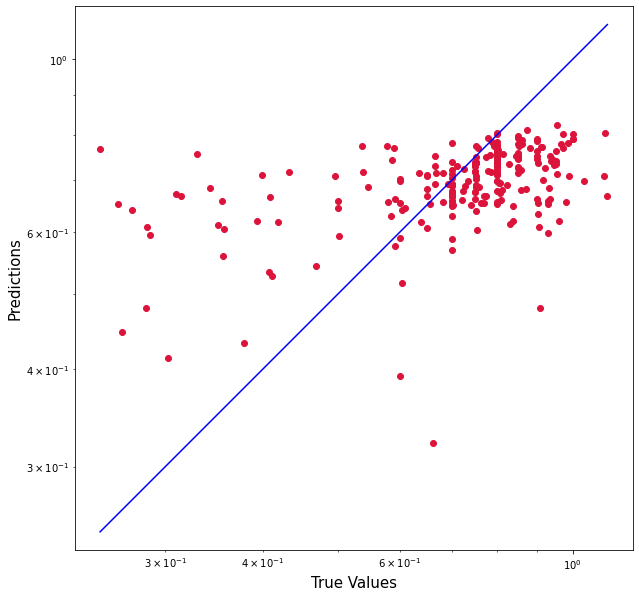

In [73]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred_reg, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred_reg), max(y_test))
p2 = min(min(y_pred_reg), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()
